In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import functools
from torch.optim import Adam
import torchvision.transforms as transforms
#from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
import tqdm
import copy

from torch.utils.data import DataLoader, Dataset


In [4]:
# model
# Defining a time-dependent score-based model

class GaussianFourierProjection(nn.Module):
    """Gaussian random features for encoding time steps."""
    def __init__(self, embed_dim, scale=30.):
        super().__init__()
        # Randomly sample weights during initialization. These weights are fixed
        # during optimization and are not trainable.
        self.W = nn.Parameter(torch.randn(embed_dim // 2) * scale, requires_grad=False)
    def forward(self, x):
        x_proj = x[:, None] * self.W[None, :] * 2 * np.pi
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)


class ScoreNet(nn.Module):
    """A time-dependent score-based model built upon U-Net architecture."""

    def __init__(self, marginal_prob_std, x_dim , hidden_depth=2, embed_dim=128, use_bn=True):
        """Initialize a time-dependent score-based network.

        Args:
          marginal_prob_std: A function that takes time t and gives the standard
            deviation of the perturbation kernel p_{0t}(x(t) | x(0)).
          channels: The number of channels for feature maps of each resolution.
          embed_dim: The dimensionality of Gaussian random feature embeddings.
        """
        super().__init__()
        self.x_dim = x_dim
        self.hidden_depth = hidden_depth
        self.embed_dim = embed_dim
        self.use_bn = use_bn

        assert hidden_depth>=1, 'hidden_depth must be greater than 0!'
        # Gaussian random feature embedding layer for time
        self.embed = nn.Sequential(GaussianFourierProjection(embed_dim=embed_dim),
             nn.Linear(embed_dim, embed_dim))

        # fc layers
        self.input = nn.Linear(x_dim, embed_dim)
        self.fc_all = nn.ModuleList([nn.Linear(embed_dim, embed_dim) for i in range(self.hidden_depth)])
        self.output = nn.Linear(embed_dim, x_dim)

        if self.use_bn:
            self.bn = nn.ModuleList([nn.BatchNorm1d(num_features=embed_dim) for i in range(self.hidden_depth)])

        # The swish activation function
        self.act = lambda x: x * torch.sigmoid(x)
        self.marginal_prob_std = marginal_prob_std


    def forward(self, x, t):
        # Obtain the Gaussian random feature embedding for t
        embed = self.act(self.embed(t))

        #
        h = self.input(x)
        # residue connections
        for i in range(self.hidden_depth):
            h = h + self.act(self.fc_all[i](h)) + embed
            if self.use_bn:
                h = self.bn[i](h)

        h = self.output(h)

        # Normalize output
        h = h / self.marginal_prob_std(t)[:, None,]
        return h


# Define the loss function
def loss_fn(model, x, marginal_prob_std, eps=1e-5):
    """The loss function for training score-based generative models.

    Args:
    model: A PyTorch model instance that represents a
      time-dependent score-based model.
    x: A mini-batch of training data.
    marginal_prob_std: A function that gives the standard deviation of
      the perturbation kernel.
    eps: A tolerance value for numerical stability.
    """
    random_t = torch.rand(x.shape[0], device=x.device) * (1. - eps) + eps #(eps,1)
    z = torch.randn_like(x)
    std = marginal_prob_std(random_t)
    perturbed_x = x + z * std[:, None]
    score = model(perturbed_x, random_t)
    loss = torch.mean(torch.sum((score * std[:, None] + z)**2, dim=1))
    return loss


def marginal_prob_std(t, sigma):
    """Compute the mean and standard deviation of $p_{0t}(x(t) | x(0))$.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The standard deviation.
    """
    # t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2 * t) - 1.) / 2. / np.log(sigma))


def diffusion_coeff(t, sigma):
    """Compute the diffusion coefficient of our SDE.

    Args:
    t: A vector of time steps.
    sigma: The $\sigma$ in our SDE.

    Returns:
    The vector of diffusion coefficients.
    """
    # return torch.tensor(sigma**t, device=device)
    return sigma**t


# data set
class MyDataset(Dataset):
    def __init__(self, x_train):
        super().__init__()
        self.x_train = x_train

    def __len__(self):
        return self.x_train.shape[0]

    def __getitem__(self, idx):
        return self.x_train[idx]



def train_model(score_model, x_sample, lr=1e-4, batch_size=1000, n_epochs=5000, print_interval=100):
    dataset = MyDataset(x_sample)
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    optimizer = Adam(score_model.parameters(), lr=lr)
    train_loss = []


    for epoch in range(n_epochs):
        avg_loss = 0.
        num_items = 0
        for x in data_loader:
            x = x.to(device)
            loss = loss_fn(score_model, x, marginal_prob_std_fn)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            avg_loss += loss.item() * x.shape[0]
            num_items += x.shape[0]
        # Print the averaged training loss so far.
        epoch_avg_loss = avg_loss / num_items
        train_loss.append(epoch_avg_loss)
        if epoch%print_interval==0:
            print(f'epoch: {epoch}\t loss: {epoch_avg_loss}')
    return train_loss


def Euler_Maruyama_sampler(score_prior, marginal_prob_std, diffusion_coeff, score_likelihood=None,
                           batch_size=64,num_steps=500,device='cpu',eps=1e-3):
    """Generate samples from score-based models with the Euler-Maruyama solver.

    Args:
    score_model: A PyTorch model that represents the time-dependent score-based model.
    marginal_prob_std: A function that gives the standard deviation of
    the perturbation kernel.
    diffusion_coeff: A function that gives the diffusion coefficient of the SDE.
    batch_size: The number of samplers to generate by calling this function once.
    num_steps: The number of sampling steps.
    Equivalent to the number of discretized time steps.
    device: 'cuda' for running on GPUs, and 'cpu' for running on CPUs.
    eps: The smallest time step for numerical stability.

    Returns:
    Samples.
    """
    t = torch.ones(batch_size, device=device)
    init_x = torch.randn(batch_size, score_prior.x_dim, device=device) \
    * marginal_prob_std(t)[:, None]
    time_steps = torch.linspace(1., eps, num_steps, device=device)
    step_size = time_steps[0] - time_steps[1]
    x = init_x
    with torch.no_grad():
        for time_step in tqdm.notebook.tqdm(time_steps):
            batch_time_step = torch.ones(batch_size, device=device) * time_step
            g = diffusion_coeff(batch_time_step)
            if score_likelihood is None:
                score = score_prior(x, batch_time_step)
            else:
                score = score_prior(x, batch_time_step) + score_likelihood(x)*torch.relu(1-2*time_step)

            # score = torch.clip(score, min=-100, max=100)

            score_norm = torch.sqrt(torch.mean(score**2, dim=1))
            adj_ratio = torch.ones_like(score_norm)
            tol = 50.
            adj_ratio[score_norm>tol] = tol/score_norm[score_norm>tol]
            # score_norm = torch.clip(score_norm, min=0, max=50)


            score = score*adj_ratio[:,None]

            # print(time_step, score)

            mean_x = x + (g**2)[:, None] * score * step_size
            x = mean_x + torch.sqrt(step_size) * g[:, None] * torch.randn_like(x)
        # Do not include any noise in the last sampling step.
    return mean_x


In [5]:
# diffusion setup
device = 'cuda' #@param ['cuda', 'cpu'] {'type':'string'}
sigma =  25.0#@param {'type':'number'}
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

torch.manual_seed(123456987)
np.random.seed(12362186)

In [6]:
# define obs system
# h(x) = x^3



def likelihood_1d(x, obs, sigma_obs):
    return torch.exp(-0.5*(x**3 - obs)**2/sigma_obs**2)

def likelihood_score_1d(x, obs, sigma_obs):
    temp1 = -(x**3 - obs)/sigma_obs**2
    temp2 = 3*x**2
    return temp2*temp1


def likelihood(x, obs, sigma_obs):
    l1 = likelihood_1d(x[:,0], obs[0], sigma_obs)
    l2 = likelihood_1d(x[:,1], obs[1], sigma_obs)
    return l1*l2

def likelihood_score(x, obs, sigma_obs):
    score_d = []
    for d in range(num_dim):
        score_d.append(likelihood_score_1d(x[:,d], obs[d], sigma_obs))
        #score_d[d] = likelihood_score_1d(x[:,d], obs[0], sigma_obs)
    
    sc = torch.stack(score_d, dim=1)
    return sc

def likelihood_score_damp(x, obs, sigma_obs, c=0.01):
    sc1 = likelihood_score_1d(x[:,0], obs[0], sigma_obs)
    sc2 = likelihood_score_1d(x[:,1], obs[1], sigma_obs)
    sc = torch.stack([sc1, sc2], dim=1)
    sc_gauss = -(x)/c

    sc_norm = torch.mean(sc**2, dim=1)
    gauss_norm = torch.mean(sc_gauss**2, dim=1)
    sc[sc_norm > gauss_norm] = sc_gauss[sc_norm > gauss_norm]
    return sc

# filtering setup

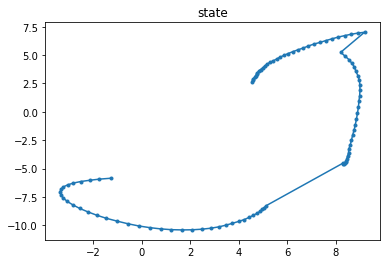

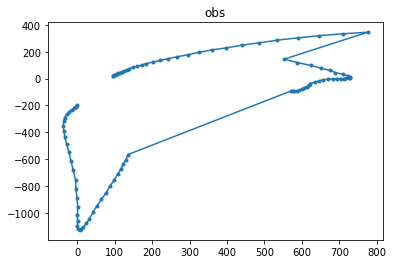

In [8]:
# Problem formulation
# state process setup
Time = 1.00
dt = 0.01
num_dim = 100
X_initial = torch.randn(num_dim)*2+4
N_T = int(Time//dt+1)
t_path = np.linspace(0, Time, N_T)
sigma_SDE = 0.1
F = 8


#dt = t_path[1] - t_path[0]


X_path = torch.zeros((N_T, num_dim))
X_path[0] = X_initial.clone()
x_new = X_initial.clone()

for i in range(N_T-1):
    # Generate true state trajectory
    x_old = X_path[i]
    
    x_new[0] = x_old[0] + ( (x_old[1] - x_old[num_dim-2])*x_old[num_dim-1] - x_old[0] + F)*dt + sigma_SDE*np.random.randn(1) * np.sqrt(dt)
    x_new[1] = x_old[1] + ( (x_old[2] - x_old[num_dim-1])*x_old[0] - x_old[1] + F)*dt + sigma_SDE*np.random.randn(1) * np.sqrt(dt)
    x_new[num_dim-1] = x_old[num_dim-1] + ( (x_old[0] - x_old[num_dim-3])*x_old[num_dim-2] - x_old[num_dim-1] + F)*dt + sigma_SDE*np.random.randn(1) * np.sqrt(dt)
    
    for d in range(2, num_dim-1):
        x_new[d] = x_old[d] + ( (x_old[d+1] - x_old[d-2])*x_old[d-1] - x_old[d] + F)*dt + sigma_SDE*np.random.randn(1) * np.sqrt(dt)
        #print(x_new[d])
        #print(d)
    #x_new[num_dim-1] = x_new[0]    

    X_path[i+1] = x_new
    
    if i==30:
        X_path[i+1] = X_path[i+1] + torch.randn(num_dim)*3
    if i==60:
        X_path[i+1] = X_path[i+1] + torch.randn(num_dim)*3

# get observation
sigma_obs = 0.5

obs_path_true = X_path**3
obs_path = obs_path_true + np.random.randn(N_T,num_dim)*sigma_obs

# plot
plt.plot(X_path[:,0],X_path[:,1],'.-',label='obs')
plt.title('state')
plt.show()

plt.plot(obs_path[:,0],obs_path[:,1],'.-',label='obs')
plt.title('obs')
plt.show()



In [9]:
# initial guess
x0 = torch.tensor(X_initial.clone(), dtype=torch.float32, device=device)
sigma0 = 0.5

print(X_initial)


tensor([ 4.5672,  2.6720,  4.6869,  6.1129,  3.0330,  4.6172,  5.5807,  4.7557,
         1.7602,  1.7656,  4.8650,  4.5329,  2.6762,  4.8137,  1.3468,  3.9708,
         0.8274,  3.2171,  4.4368,  2.1885,  2.6863,  4.2668,  4.7033,  1.7479,
         4.6993,  6.3499,  3.0749,  5.5497,  4.6910,  1.9417,  4.0838,  3.2442,
         3.1635,  3.8746,  2.7106,  3.3441,  2.2606,  0.8433,  2.9846,  3.4501,
         3.5797,  1.6196,  2.9484,  5.8204,  6.4675,  7.0187,  7.3860,  2.0554,
         2.9413,  4.9925,  3.1469,  3.8502,  6.4035, -0.1024,  6.5344,  3.0568,
         6.0976,  3.1239,  4.0684,  1.2053,  6.2914,  5.1576,  2.3653,  4.5269,
         2.3400,  6.3962,  3.9268,  8.4407, -1.7358,  5.2227,  2.2953,  2.1751,
         7.4454,  4.0238,  3.9543,  3.7247,  5.4899,  3.6605,  1.3932,  0.6019,
         1.9462,  3.0790, -0.8554,  3.0425,  2.7911,  6.3440,  1.6272, -0.6897,
         6.2654,  4.5791,  3.8711,  4.8781,  3.0438,  3.7170,  0.8976,  2.9607,
         5.7311,  6.6993,  3.4146,  3.31

C:\Users\10576\AppData\Local\Temp\ipykernel_21940\2126229071.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x0 = torch.tensor(X_initial.clone(), dtype=torch.float32, device=device)


In [12]:
# Training initialize
x_dim = num_dim
hidden_depth  = 2
embed_dim = 200
use_bn = False

score_prior_old = ScoreNet(marginal_prob_std=marginal_prob_std_fn, x_dim=x_dim,
                           hidden_depth=hidden_depth, embed_dim=embed_dim, use_bn=use_bn)

score_prior_new = ScoreNet(marginal_prob_std=marginal_prob_std_fn, x_dim=x_dim,
                           hidden_depth=hidden_depth, embed_dim=embed_dim, use_bn=use_bn)

score_prior_old = score_prior_old.to(device)
score_prior_new = score_prior_new.to(device)

# initial samples
sample_size = 50000
x_init = x0 + torch.randn(sample_size,num_dim, dtype=torch.float32, device=device)*sigma0
train_loss = train_model(score_prior_old, x_sample=x_init, batch_size=50000, lr=0.01, n_epochs=1000, print_interval=100)

likelihood_score_fn = None
score_prior_new = score_prior_old

epoch: 0	 loss: 581.2781982421875
epoch: 100	 loss: 61.3089599609375
epoch: 200	 loss: 49.712135314941406
epoch: 300	 loss: 46.930580139160156
epoch: 400	 loss: 46.411293029785156
epoch: 500	 loss: 45.494510650634766
epoch: 600	 loss: 45.932884216308594
epoch: 700	 loss: 45.50865936279297
epoch: 800	 loss: 45.55564880371094


KeyboardInterrupt: 

In [11]:
est_all = []
x_prior = x_init.clone()
for i in range(N_T-1):
    print(i)
    
    score_prior_old = score_prior_new
    score_prior_new = copy.deepcopy(score_prior_new)
    
    # sample initial distribution
    x_init = Euler_Maruyama_sampler(score_prior_old,marginal_prob_std_fn, diffusion_coeff_fn,score_likelihood=likelihood_score_fn,
                                   batch_size=sample_size,num_steps=800,device=device)
    est_all.append(torch.mean(x_init, dim=0).cpu().numpy())

    # solve for forward SDE (prediction)
    x_prior[:,0] = x_init[:,0] + ( (x_init[:,1] - x_init[:,num_dim-2])*x_init[:,num_dim-1] - x_init[:,0] + F)*dt + torch.randn(sample_size,device=device) * np.sqrt(dt)
    x_prior[:,1] = x_init[:,1] + ( (x_init[:,2] - x_init[:,num_dim-1])*x_init[:,0] - x_init[:,1] + F)*dt + torch.randn(sample_size,device=device) * np.sqrt(dt)
    x_prior[:,num_dim-1] = x_init[:,num_dim-1] + ( (x_init[:,0] - x_init[:,num_dim-3])*x_init[:,num_dim-2] - x_init[:,num_dim-1] + F)*dt + torch.randn(sample_size,device=device) * np.sqrt(dt)
    for d in range(1, num_dim-2):
        x_prior[:,d] = x_init[:,d] + ( (x_init[:,d+1] - x_init[:,d-2])*x_init[:,d-1] - x_init[:,d] + F)*dt + torch.randn(sample_size, device=device) * np.sqrt(dt)
      
    

    
    print('est: ',est_all[i])
    print('state: ',X_path[i])

    # train model for prior distribution
    train_loss = train_model(score_prior_new, x_sample=x_prior,
                             batch_size=50000,lr=0.001, n_epochs=1000, print_interval=100)

    # new observation
    #obs_current = torch.from_numpy(obs_path[i+1,:]).float().to(device)
    obs_current = np.array(obs_path[i+1,:])

    # update likelihood function
    likelihood_score_fn = functools.partial(likelihood_score, obs=obs_current, sigma_obs=sigma_obs)
    # likelihood_score_fn = functools.partial(likelihood_score_damp, obs=obs_current, sigma_obs=sigma_obs, c=0.1)
    # next iteration

# last estimation
# sample initial distribution
x_init = Euler_Maruyama_sampler(score_prior_old,marginal_prob_std_fn, diffusion_coeff_fn,score_likelihood=likelihood_score_fn,
                               batch_size=sample_size,num_steps=500,device=device)
est_all.append(torch.mean(x_init, dim=0).cpu().numpy())

est_all = np.array(est_all)


0


  0%|          | 0/800 [00:00<?, ?it/s]

est:  [-4909.2295   1277.6356    913.638   -4943.1772  -2339.0706   2675.6243
 -3222.405   -2605.9133   3275.1174  -1970.3478  -5012.405    3476.7595
  2520.208   -5517.211   -1981.2152  -3904.2266  -2489.9685   1805.7148
 -3561.712   -2230.8896   2177.0725  -1921.335    1501.686    2515.7275
   242.24704  1173.638    2157.316   -4422.9404  -3797.2163   4225.715
  1419.2358  -3082.592   -2859.9058  -3789.2395  -2996.066   -4020.534
 -2640.2224  -4134.4023   2673.7026   2149.8347  -2350.7046   3059.8657
  3015.3474   3181.0813  -3466.7935  -2118.6235  -2228.2668  -2810.8213
  2147.323   -4298.6323   2102.7922  -2865.3887   4256.666    3118.8142
 -2969.038    2311.4802  -3817.0598   4106.7876   2118.4717  -1959.4569
 -5369.622     930.81415 -3733.512    2647.372   -2296.222   -2640.313
 -2783.088   -5024.806    2852.1147   3305.182    2568.4358   -194.5184
  3104.743   -4974.0244   1673.4619   1217.3805  -3118.402   -3620.3916
 -4860.1646   2719.4067   3943.3235   3275.3235  -2177.6792  

KeyboardInterrupt: 

In [ ]:
np.savetxt('Est_all_100d.txt', est_all)
np.savetxt('X_path_100d.txt', X_path)
np.savetxt('obs_path_100d.txt', obs_path)